# Semester 3 Coding Portfolio Topic 4 Summative:
# Logistic Regression

In this notebook, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [1]:
# TODO: Please enter your student number here
STUDENT_NUMBER = ...

# SUMMATIVE ASSESSMENT

For this summative assignment, we ask you to find a dataset from an internet source of choice. You will then analyze this dataset using logistic regression and interpret the results.

The general assessment criteria for all summative assignments are mentioned in the assignment description on Canvas. Each notebook also has a few specific criteria we look for; make sure you fulfil them in your approach to this assignment.
In general, make sure this notebook represents a complete project: Write an explanation of what you are hoping to achieve with your analysis, document your code well, and present results in a comprehensive way.

## Assessment criteria specific to logistic regression
 - Fitted both homogeneous and heterogeneous probability models, ensuring no errors or warnings and checking for multicollinearity through coefficient inspection.
 - Used and plotted simulations to assess coefficient significance.
 - Generated predicted probabilities and plotted posterior predictive distributions with visualizations, including histograms or intervals for uncertainty.
 - Correctly interpreted coefficients and plots in terms of magnitude, direction, statistical significance, and odds rather than log-odds.
 - Compared homogeneous and heterogeneous models using the AIC criterion and provided an accurate interpretation of the results.
 - Calculates and plots a correlation matrix to explore underlying relationships in the data.
 - Performs model selection via a sensible method, such as cross-validation, split in train-validation- test, or use of AIC or other complexity-adjusted metrics.
 - Generates predicted probabilities for different observations. If they only predicted class, give half a point.
 - By plotting or in some other way, presents the predicted probabilities for at least 1 observation, and shows comparison against true class.
 - Computes the generalisation error for a sensible metric of choice.

Pick a dataset of your choice. Please ensure your dataset is a csv file under 100MB named sem3_topic4_logreg_summative_data.csv

<table>
<tr>
<td style="vertical-align: top; padding-right: 20px;">

Reproductive health is often surrounded by stigma, and conditions like **PCOS** remain widely misunderstood. To help address this gap, I chose to build, evaluate, and compare logistic regression models that predict whether an individual is diagnosed with PCOS using demographic, lifestyle, and clinical features. This approach supports greater awareness and understanding of PCOS by identifying key factors associated with the condition.

<br><br>

Polycystic ovary syndrome (**PCOS**) is the most common hormonal disorder in women of reproductive age. The name comes from the observation of small follicles (or “cysts”) that often appear on the ovaries. However, not everyone with PCOS has these follicles, and they are not the cause of the condition.

<br><br>

The dataset simulates the prevalence and key risk factors of Polycystic Ovary Syndrome among women aged 15–49 across the world’s 75 most populous countries. It consists of **120,000 records** and **17 variables** that reflect real-world patterns and variability in PCOS diagnosis and related factors.

<br><br>

<em>PCOS definition source: Wikipedia.com  
Dataset source: Kaggle.com</em>

</td>

<td>
<!-- Replace with your image when ready -->
<img src="pcos.png" width="1550">
</td>

</tr>
</table>


In [2]:
# Do NOT modify the contents of this cell. Start your customization in the next one!
import pandas as pd

custom_data_path = "sem3_topic4_logreg_summative_data.csv"
custom_df = pd.read_csv(custom_data_path)

**IMPORTS**

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    log_loss,
    confusion_matrix,
    classification_report,
    roc_curve,
    brier_score_loss,
)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression


(1) **DATA PREPARATION AND EXPLORATION**

(1.1) **EXPLORATION**

In [4]:
df = pd.read_csv("sem3_topic4_logreg_summative_data.csv")

print(f"Number of rows: {df.shape[0]:,}")      
print(f"Number of columns: {df.shape[1]}")
display(df.head())

print(f"\nMissing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])  # Only show columns with missing values


Number of rows: 120,000
Number of columns: 17


,Country,Age,BMI,Menstrual Regularity,Hirsutism,Acne Severity,Family History of PCOS,Insulin Resistance,Lifestyle Score,Stress Levels,Urban/Rural,Socioeconomic Status,Awareness of PCOS,Fertility Concerns,Undiagnosed PCOS Likelihood,Ethnicity,Diagnosis
0,Madagascar,26,Overweight,Regular,Yes,Severe,Yes,Yes,2,Low,Rural,High,Yes,No,0.107938,Hispanic,Yes
1,Vietnam,16,Underweight,Regular,Yes,NaN,No,Yes,4,High,Rural,Middle,Yes,No,0.156729,Other,No
2,Somalia,41,Normal,Regular,No,Moderate,No,No,7,Medium,Urban,Middle,Yes,Yes,0.202901,Other,No
3,Malawi,27,Normal,Irregular,No,Mild,No,No,10,Low,Urban,High,Yes,No,0.073926,Caucasian,Yes
4,France,26,Overweight,Irregular,Yes,NaN,No,No,7,Medium,Urban,Middle,No,No,0.229266,Caucasian,No



Missing Values:
Acne Severity    60085
dtype: int64


**df.desribe INTERPRITATION**


1. count inspection shows df has no NaNs for numeric fields


2. mean, std -> av age = 32 & std 10


No expectetation to see any NaNs since df is high quality, however still double check

(1.2) **DATA CLEANING**

Since 50% data for acne severity is missing drop the whole column 

In [5]:
df = df.drop(columns=['Acne Severity', 'Country', 'Undiagnosed PCOS Likelihood'])


print("\n Dropped (1): 'Acne Severity' - 50% of data missing, "
                    "(2): Country column - too many unique values, "
                    "(3): 'Undiagnosed PCOS Likelihood' - target variable.")
print(f"Remaining columns: {df.shape[1]}")


 Dropped (1): 'Acne Severity' - 50% of data missing, (2): Country column - too many unique values, (3): 'Undiagnosed PCOS Likelihood' - target variable.
Remaining columns: 14


**FINAL NaN CHECK**

In [6]:
total_missing = df.isnull().sum().sum()
print(f"Total missing values in dataset: {total_missing}")

Total missing values in dataset: 0


(1.3) **FEATURE ENGINEERING**


Earlier when did df types most of the values in df are objects. So in order for model to understand them each value needs to be encoded (0/1). Encoding separate since both binary and binary with other values  present.

In [7]:
#regular binary encoding
df_encoded = df.copy() #cope to not touch original df

binary_columns = [
    'Hirsutism',
    'Family History of PCOS',
    'Insulin Resistance',
    'Awareness of PCOS',
    'Fertility Concerns',
    'Diagnosis'
]

for col in binary_columns:
    df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0})
    print(f"Encoded {col}: Yes into 1, No into 0")

Encoded Hirsutism: Yes into 1, No into 0
Encoded Family History of PCOS: Yes into 1, No into 0
Encoded Insulin Resistance: Yes into 1, No into 0
Encoded Awareness of PCOS: Yes into 1, No into 0
Encoded Fertility Concerns: Yes into 1, No into 0
Encoded Diagnosis: Yes into 1, No into 0


In [8]:
#nominal binary encoding 
df_encoded['Menstrual Regularity'] = df_encoded['Menstrual Regularity'].map({
    'Regular': 0, 
    'Irregular': 1
})
print(f"encoded Menstrual Regularity: regular into 0, irregular into 1")

df_encoded['Urban/Rural'] = df_encoded['Urban/Rural'].map({
    'Rural': 0, 
    'Urban': 1
})
print(f"encoded urban/rural: rural intoo 0, urban into 1")

encoded Menstrual Regularity: regular into 0, irregular into 1
encoded urban/rural: rural intoo 0, urban into 1


In [9]:
#natural order encoding
bmi_order = {'Underweight': 0, 'Normal': 1, 'Overweight': 2, 'Obese': 3}
df_encoded['BMI'] = df_encoded['BMI'].map(bmi_order)
print(f"encoded BMI: Underweight into 0, Normal into 1, Overweight into 2, Obese into 3")

stress_order = {'Low': 0, 'Medium': 1, 'High': 2}
df_encoded['Stress Levels'] = df_encoded['Stress Levels'].map(stress_order)
print(f"encoded Stress Levels: Low into 0, Medium into 1, High into 2")

socioecon_order = {'Low': 0, 'Middle': 1, 'High': 2}
df_encoded['Socioeconomic Status'] = df_encoded['Socioeconomic Status'].map(socioecon_order)
print(f"encoded Socioeconomic Status: Low into 0, Middle into 1, High into 2")

encoded BMI: Underweight into 0, Normal into 1, Overweight into 2, Obese into 3
encoded Stress Levels: Low into 0, Medium into 1, High into 2
encoded Socioeconomic Status: Low into 0, Middle into 1, High into 2


In [10]:
ethnicity_dummies = pd.get_dummies(df_encoded['Ethnicity'], prefix='Ethnicity', drop_first=True)
print(f"New columns created: {list(ethnicity_dummies.columns)}")

df_encoded = pd.concat([df_encoded, ethnicity_dummies], axis=1)
df_encoded = df_encoded.drop('Ethnicity', axis=1)

print("Ethnicity one-hot encoded")

New columns created: ['Ethnicity_Asian', 'Ethnicity_Caucasian', 'Ethnicity_Hispanic', 'Ethnicity_Other']
Ethnicity one-hot encoded


**FINAL ENCODED DF CHECK**

In [11]:
print(f"Shape: {df_encoded.shape}")
print(f"\nColumns ({len(df_encoded.columns)}):")
print(list(df_encoded.columns))

Shape: (120000, 17)

Columns (17):
['Age', 'BMI', 'Menstrual Regularity', 'Hirsutism', 'Family History of PCOS', 'Insulin Resistance', 'Lifestyle Score', 'Stress Levels', 'Urban/Rural', 'Socioeconomic Status', 'Awareness of PCOS', 'Fertility Concerns', 'Diagnosis', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Ethnicity_Hispanic', 'Ethnicity_Other']


(1.4) **TRAIN TEST SPLIT**

Separate features x from target y

In [12]:
X = df_encoded.drop('Diagnosis', axis=1)  # All columns EXCEPT Diagnosis
y = df_encoded['Diagnosis']                # ONLY the Diagnosis column

print(f"Features (X): {X.shape[0]:,} rows x {X.shape[1]} columns")
print(f"Target (y): {y.shape[0]:,} values")

Features (X): 120,000 rows x 16 columns
Target (y): 120,000 values


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,       #20% test size
    random_state=42,     #common random state for reproducibility
    stratify=y           #same proportions for each class in train/test (keeps the same pcos yes/no ratio)
)

print(f"\nSplit complete!")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Test set:     {X_test.shape[0]:,} samples")


Split complete!
  Training set: 96,000 samples
  Test set:     24,000 samples


(2) **EXPLORATORY DATA ANALYSIS**

(2.1) **CLASS IMBALANCE VISUAL**


Earlier it was seen that in the dataset only 10% of people were diagnosed with pcos. This creates a class/category imbalance so gotta keep it in mind before modelling.

In [14]:
print("\nValue counts:")
print(train_data['Diagnosis'].value_counts())
print(f"\nPCOS rate: {train_data['Diagnosis'].mean()*100:.2f}%")


Value counts:


NameError: name 'train_data' is not defined

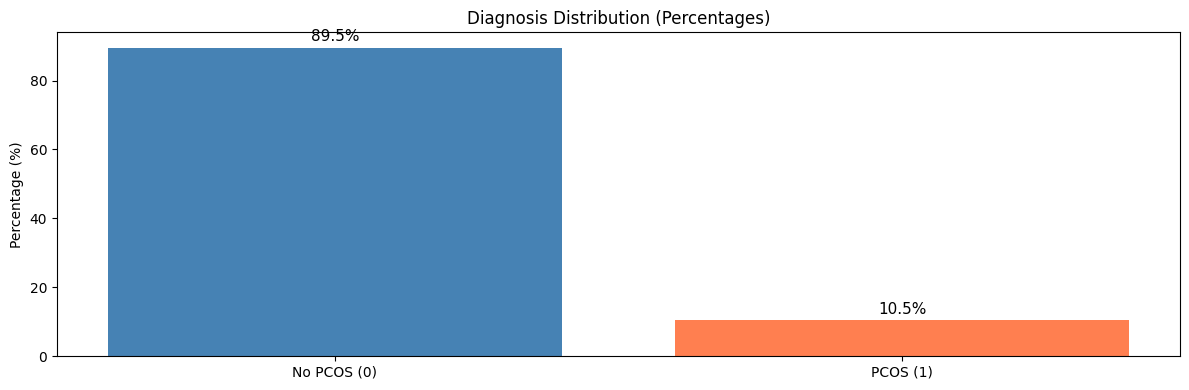


  Note: Classes are imbalanced -> ~10% PCOS vs ~90% No PCOS
   This is medical data special and also shows an interesting point about PCOS diagnosising practices.


In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

percentages = train_data['Diagnosis'].value_counts(normalize=True) * 100
bars = ax.bar(['No PCOS (0)', 'PCOS (1)'], percentages.values,
              color=['steelblue', 'coral'])
ax.set_ylabel('Percentage (%)')
ax.set_title('Diagnosis Distribution (Percentages)')

for bar, pct in zip(bars, percentages.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


print("\n  Note: Classes are imbalanced -> ~10% PCOS vs ~90% No PCOS")
print("   This is medical data special and also shows an interesting point about PCOS diagnosising practices.")

(2.2) **CORRELATION MATRIX**

In [ ]:
correlation_matrix = train_data.corr()

#table
print("\nCorrelation values (rounded to 2 decimal places):")
print(correlation_matrix.round(2))


Correlation values (rounded to 2 decimal places):
                         Age   BMI  Menstrual Regularity  Hirsutism  \
Age                     1.00  0.01                  0.00       0.01   
BMI                     0.01  1.00                  0.00      -0.00   
Menstrual Regularity    0.00  0.00                  1.00       0.01   
Hirsutism               0.01 -0.00                  0.01       1.00   
Family History of PCOS  0.00  0.00                 -0.00      -0.00   
Insulin Resistance      0.00 -0.00                  0.00       0.00   
Lifestyle Score         0.00  0.00                  0.00      -0.00   
Stress Levels           0.00  0.00                 -0.00      -0.00   
Urban/Rural             0.01  0.00                 -0.00      -0.00   
Socioeconomic Status   -0.00  0.00                  0.00      -0.00   
Awareness of PCOS       0.00  0.00                  0.00      -0.00   
Fertility Concerns     -0.00  0.00                  0.00       0.00   
Ethnicity_Asian         0.

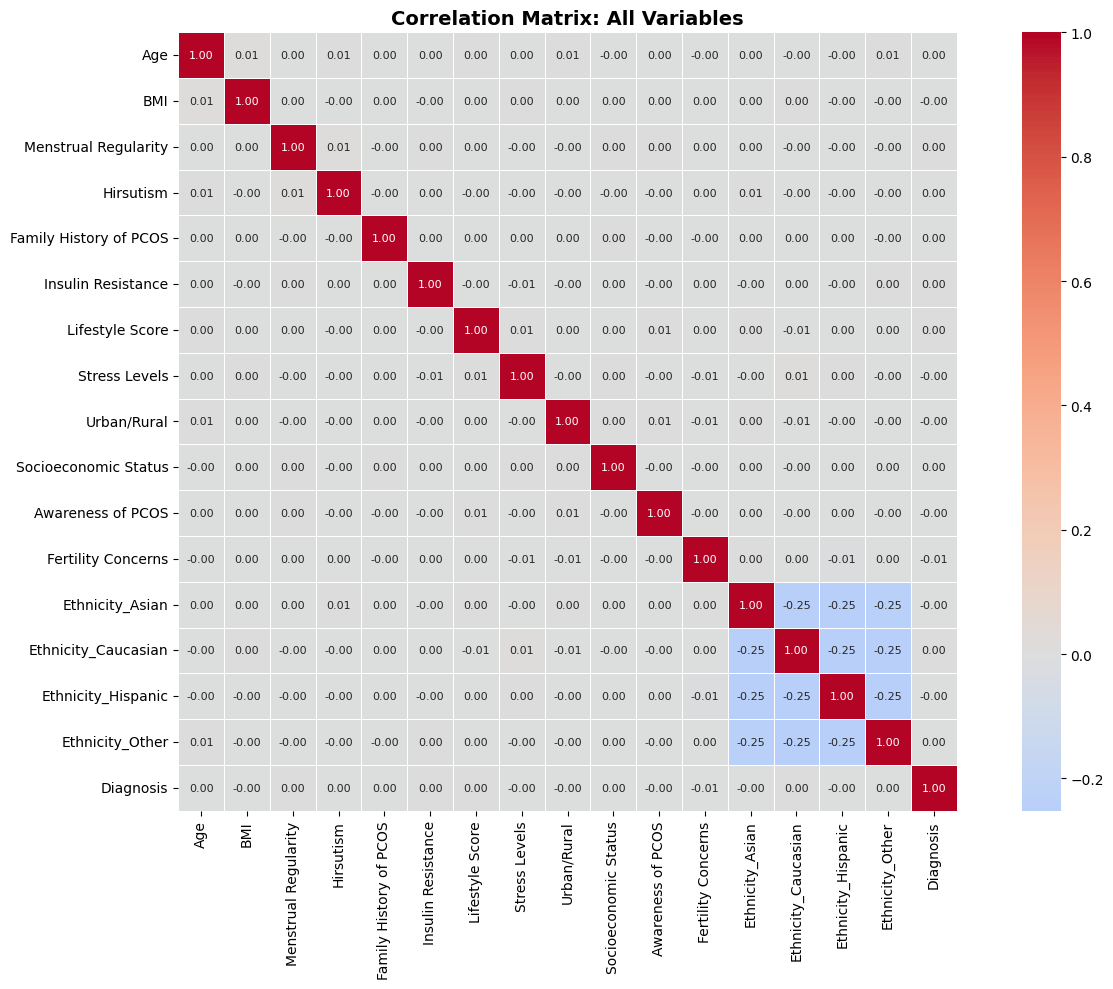

In [ ]:
# Visualise as a heatmap
plt.figure(figsize=(14, 10))

sns.heatmap(
    correlation_matrix,
    annot=True,          # Show numbers in cells
    fmt='.2f',           # 2 decimal places
    cmap='coolwarm',     # Blue = negative, Red = positive
    center=0,            # White at 0
    square=True,         # Square cells
    linewidths=0.5,      # Lines between cells
    annot_kws={'size': 8}  # Font size for numbers
)

plt.title('Correlation Matrix: All Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**ISSUES**


Both table and visual correlation matrix indicate EXTREMELY low correlations. From now on I will assume the dataset I am using is AI generated.

**CONCLUSIONS**


1. extreme class imbalance


2. AI generated dataset (shame on fake comments on Kaggle about its perfection)


3. extremely weak correlations ~0.00 -> no linear relationship


4. pcos rates are nearly IDENTICAL across all feature groups


5. even though these findings still nothing prevents to keep using the same dataset for log regression

(3) **HOMOGENEOUS MODEL - only CLINICAL predictors**

In [ ]:
formula_homogeneous = 'Diagnosis ~ BMI + Hirsutism + Q("Menstrual Regularity") + Q("Insulin Resistance") + Q("Family History of PCOS")'

model_homogeneous = smf.logit(formula_homogeneous, data=train_data).fit()

# Display summary
print(model_homogeneous.summary())

Optimization terminated successfully.
         Current function value: 0.335823
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                96000
Model:                          Logit   Df Residuals:                    95994
Method:                           MLE   Df Model:                            5
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:               6.058e-05
Time:                        15:38:45   Log-Likelihood:                -32239.
converged:                       True   LL-Null:                       -32241.
Covariance Type:            nonrobust   LLR p-value:                    0.5629
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.1377      0.027    -79.223      0.000   

**INTERPRITATIONS HELPERS**


1. MLE -> max likelehood estimation, st way to estima logred coeffs


2. Converged: true -> numerical optimizer stopped cuz convergence criteria satisf aka solution = found


3. Covariance type: nonrobust -> ?


4. Df residuals -> n of obs - n of estim params


5. Df model -> n of predictors(-intercept)


6. Log likelihood -> 


7. Pseudo r squared -> likelihood analogue of r^2 


8. LL null -> log likelihood of null model (only intercept)


9. log likelihood vs ll null = how much predictors improved fit


10. LLR p value -> higher value = less significance over null


11. residual -> y_actual-y_predicted


12. model’s baseline probability of Diagnosis = 1 is exp(−2.1377)/(1+exp(−2.1377)) ≈ 0.106


13. **log regression model predicts log-odds**:


{B0} = (each feature at reference lvl (0)) plugging cuz intercept = log-odds baseline before any predictor shifts it


14. log-odd -> natural log of the odds of an event -> Diagnosis = 1, odds = p / (1 − p), and log-odds = ln(p / (1 − p)) -> logreg models log-odds as a linear combination of events

In [ ]:
X_homogeneous = train_data[['BMI', 'Hirsutism', 'Menstrual Regularity', 
                             'Insulin Resistance', 'Family History of PCOS']]
X_with_const = sm.add_constant(X_homogeneous)

vif_data = pd.DataFrame({
    'Feature': X_homogeneous.columns,
    'VIF': [variance_inflation_factor(X_with_const.values, i+1) 
            for i in range(len(X_homogeneous.columns))]
})

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                  Feature       VIF
0                     BMI  1.000018
1               Hirsutism  1.000071
2    Menstrual Regularity  1.000071
3      Insulin Resistance  1.000017
4  Family History of PCOS  1.000009


**INTERPRITATION HELPER**


1. variance how spread out values are round mean = fluctuation average


2. VIF how much multicollinearity inflates coeff's variance 


**WHY VIF matters**


When predictors are highly correlated, the model can’t distinguish which one should “get credit” for explaining the outcome. Their effects overlap, so many combinations of coefficients fit almost equally well. Mathematically, that makes the design matrix nearly singular, which blows up the inverse used to compute coefficient estimates. As a result, tiny changes in the data lead to large swings in those coefficients—i.e., their estimated variance becomes large. The VIF captures this: high multicollinearity (R² near 1 when regressing a predictor on the others) makes 1 − R² tiny, so 1 / (1 − R²) becomes big, indicating inflated variance.

In [ ]:
homogeneous_results = {
    'aic': model_homogeneous.aic,
    'log_likelihood': model_homogeneous.llf
}

print(f"\nAIC: {model_homogeneous.aic:.2f}")


AIC: 64489.93


In [ ]:
# Simple model:    Diagnosis ~ BMI + Hirsutism
#                 → Fits OK

# Complex model:   Diagnosis ~ BMI + Hirsutism + Age + Ethnicity + 
#                             Stress + Urban + ... (20 variables)
#                 → Fits better! But...

In [ ]:
# AIC&BIC balance -> Score = How well it fits  +  Penalty for complexity
#                               (want this high)     (want this low)

In [ ]:
# AIC = -2(Log-Likelihood) + 2(number of parameters)
# BIC = -2(Log-Likelihood) + log(n)(number of parameters)
#                           ↑
#                           Bigger penalty when you have lots of data

(4) **HETEROGENEOUS MODEL - demographics & interactions**

In [ ]:
formula_heterogeneous = '''
Diagnosis ~ BMI + Hirsutism + Q("Menstrual Regularity") + Q("Insulin Resistance") + Q("Family History of PCOS") 
            + Age + Q("Socioeconomic Status") + Q("Urban/Rural")
            + Ethnicity_Asian + Ethnicity_Caucasian + Ethnicity_Hispanic + Ethnicity_Other
            + Q("Insulin Resistance"):Ethnicity_Asian
'''

# Fit the model
model_heterogeneous = smf.logit(formula_heterogeneous, data=train_data).fit()

# Display summary
print(model_heterogeneous.summary())

Optimization terminated successfully.
         Current function value: 0.335806
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                96000
Model:                          Logit   Df Residuals:                    95986
Method:                           MLE   Df Model:                           13
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:               0.0001111
Time:                        15:38:45   Log-Likelihood:                -32237.
converged:                       True   LL-Null:                       -32241.
Covariance Type:            nonrobust   LLR p-value:                    0.8934
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                         

In [ ]:
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                  Feature       VIF
0                     BMI  1.000018
1               Hirsutism  1.000071
2    Menstrual Regularity  1.000071
3      Insulin Resistance  1.000017
4  Family History of PCOS  1.000009


how much the variance of a regression coefficient is inflated cuz that predictor is linearity related to others

In [ ]:
heterogeneous_results = {
    'aic': model_heterogeneous.aic,
    'log_likelihood': model_heterogeneous.llf
}

print(f"\nAIC: {model_heterogeneous.aic:.2f}")


AIC: 64502.67


**HOME&HETERO MODEL COMPARISON**

In [ ]:
print("MODEL COMPARISON: Homogeneous vs Heterogeneous")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['Homogeneous', 'Heterogeneous'],
    'Predictors': [5, 12],
    'AIC': [homogeneous_results['aic'], heterogeneous_results['aic']]
})

print(comparison_df.to_string(index=False))

MODEL COMPARISON: Homogeneous vs Heterogeneous
        Model  Predictors          AIC
  Homogeneous           5 64489.933883
Heterogeneous          12 64502.673943


In [ ]:
aic_diff = heterogeneous_results['aic'] - homogeneous_results['aic']

print(f"""
AIC Difference: {aic_diff:.2f} (Heterogeneous is higher by {aic_diff:.2f})

Conclusion:
- The HOMOGENEOUS model has lower AIC 
- Adding demographics and interactions did NOT improve the model
- The simpler model (5 clinical predictors) is preferred
- Extra complexity is not justified by better fit
""")


AIC Difference: 12.74 (Heterogeneous is higher by 12.74)

Conclusion:
- The HOMOGENEOUS model has lower AIC 
- Adding demographics and interactions did NOT improve the model
- The simpler model (5 clinical predictors) is preferred
- Extra complexity is not justified by better fit



**WHY**


1. the dataset unfortunately has no real signal, aka features dont predict


2. adding more feats didnt improve fit


3. adding feats = complexity penalty


4. simpler model better AIC -> simple wins


(5) **COEFFICIENT SIGNIFICANCE - SIMULATION**


PS: since homogenous model performed better (AIC) I will use it

In [ ]:
coefficients = model_homogeneous.params
covariance_matrix = model_homogeneous.cov_params()

print("Coefficients (point estimates):")
print(coefficients.round(4))

Coefficients (point estimates):
Intercept                     -2.1377
BMI                           -0.0153
Hirsutism                      0.0089
Q("Menstrual Regularity")      0.0271
Q("Insulin Resistance")        0.0237
Q("Family History of PCOS")    0.0012
dtype: float64


In [ ]:
np.random.seed(42)
n_simulations = 10000

simulated_coefs = np.random.multivariate_normal(
    mean=coefficients,
    cov=covariance_matrix,
    size=n_simulations
)

sim_df = pd.DataFrame(simulated_coefs, columns=coefficients.index)
print(f"Simulated {n_simulations:,} coefficient sets")

Simulated 10,000 coefficient sets


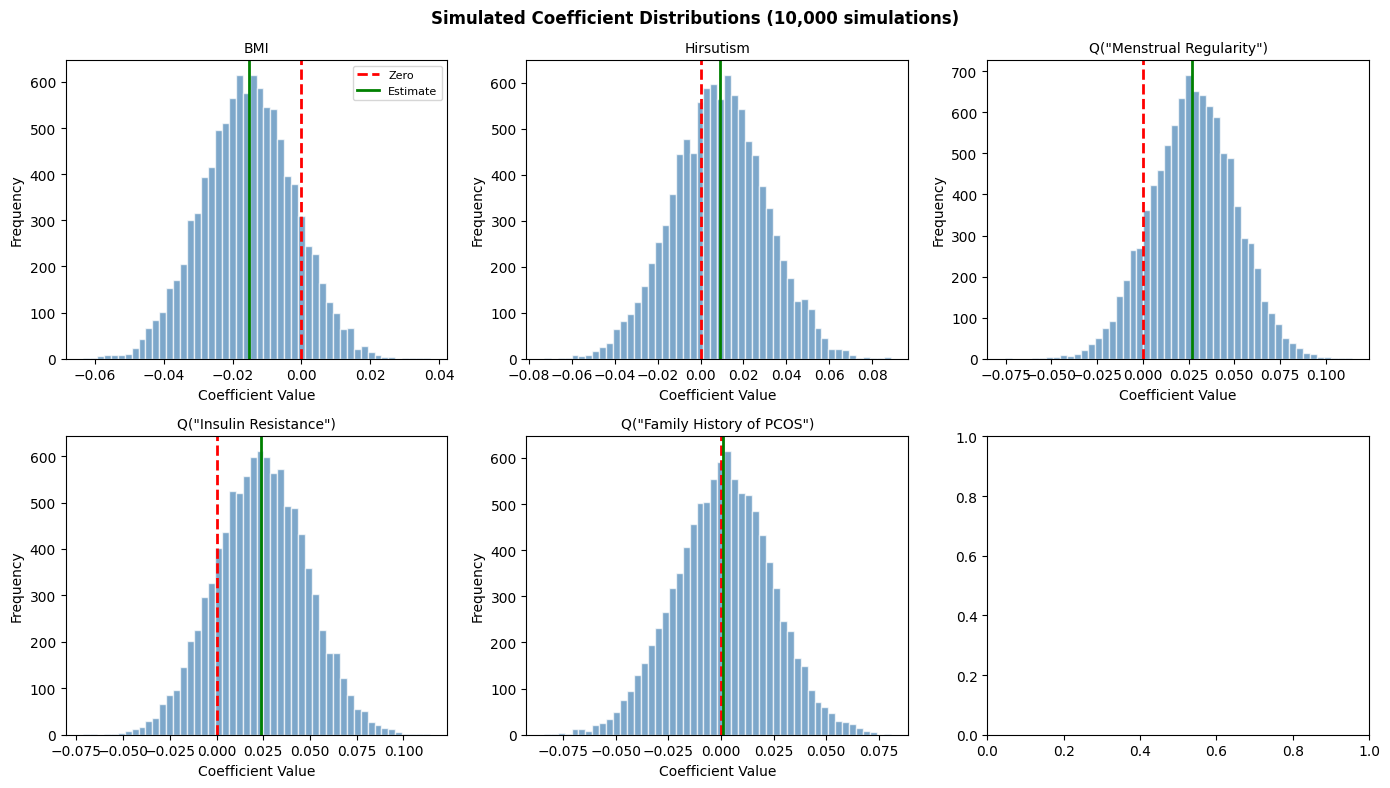

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

features = coefficients.index[1:]  # Skip Intercept

for i, feature in enumerate(features):
    ax = axes[i]
    ax.hist(sim_df[feature], bins=50, color='steelblue', alpha=0.7, edgecolor='white')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
    ax.axvline(x=coefficients[feature], color='green', linestyle='-', linewidth=2, label='Estimate')
    ax.set_title(f'{feature}', fontsize=10)
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Frequency')

axes[0].legend(fontsize=8)
plt.suptitle('Simulated Coefficient Distributions (10,000 simulations)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

1. ALL clinical predictors have confidence intervals that include 0


2. hence We cannot conclude that ANY of these features have a real effect on PCOS diagnosis 


3. This confirms our EDA finding: The features appear to be randomly assigned, independent of diagnosis

In [ ]:
print("""
Simulation Results:

- All 5 clinical predictors have 95% credible intervals that INCLUDE zero
- This means none of the coefficients are statistically significant
- We cannot conclude that any feature has a real effect on PCOS diagnosis

- Only the Intercept is significant (CI excludes zero)
  - This just tells us the baseline probability of PCOS (~10.5%)

This confirms our EDA finding: the features in this dataset 
do not have meaningful predictive power for PCOS diagnosis.
""")


Simulation Results:

- All 5 clinical predictors have 95% credible intervals that INCLUDE zero
- This means none of the coefficients are statistically significant
- We cannot conclude that any feature has a real effect on PCOS diagnosis

- Only the Intercept is significant (CI excludes zero)
  - This just tells us the baseline probability of PCOS (~10.5%)

This confirms our EDA finding: the features in this dataset 
do not have meaningful predictive power for PCOS diagnosis.



In [ ]:
quantiles = sim_df.quantile([0.025, 0.975])
ci_df = pd.DataFrame({
    'Feature': coefficients.index,
    'Estimate': coefficients.values,
    'CI Lower (2.5%)': quantiles.loc[0.025].values,
    'CI Upper (97.5%)': quantiles.loc[0.975].values
})
ci_df['Includes Zero?'] = ci_df['CI Lower (2.5%)'].lt(0) & ci_df['CI Upper (97.5%)'].gt(0)
print(ci_df.round(4).to_string(index=False))


                    Feature  Estimate  CI Lower (2.5%)  CI Upper (97.5%)  Includes Zero?
                  Intercept   -2.1377          -2.1900           -2.0838           False
                        BMI   -0.0153          -0.0414            0.0104            True
                  Hirsutism    0.0089          -0.0342            0.0516            True
  Q("Menstrual Regularity")    0.0271          -0.0172            0.0719            True
    Q("Insulin Resistance")    0.0237          -0.0240            0.0706            True
Q("Family History of PCOS")    0.0012          -0.0443            0.0460            True


CI -> range of plausible values for the true effect (use height example)

In [ ]:
# if CI includes zero:
#   ──────[─────0─────]──────
#         ↑    ↑     ↑
#       Lower  │   Upper
#              │
#        Zero is INSIDE the range
#        → Effect might be zero!
#        → NOT statistically significant


#if CI excludes zero:
#   ──────[─────]──────0──────
#         ↑     ↑      ↑
#       Lower Upper   Zero is OUTSIDE
#              │
#        Zero is NOT in the range
#        → Effect is probably real
#        → Statistically significant

(6) **ODDS RATIO INTERPRITATION**

In [ ]:
# Get coefficients and confidence intervals
log_odds = model_homogeneous.params
conf_int = model_homogeneous.conf_int()

# Convert to odds ratios (exponentiate)
odds_ratios = np.exp(log_odds)
ci_lower = np.exp(conf_int[0])
ci_upper = np.exp(conf_int[1])

# Create summary table
odds_df = pd.DataFrame({
    'Feature': log_odds.index,
    'Log-Odds': log_odds.values,
    'Odds Ratio': odds_ratios.values,
    'CI Lower (2.5%)': ci_lower.values,
    'CI Upper (97.5%)': ci_upper.values
})

# Add interpretation column
odds_df['Significant?'] = ~((ci_lower < 1) & (ci_upper > 1)).values

print(odds_df.round(4).to_string(index=False))

                    Feature  Log-Odds  Odds Ratio  CI Lower (2.5%)  CI Upper (97.5%)  Significant?
                  Intercept   -2.1377      0.1179           0.1119            0.1243          True
                        BMI   -0.0153      0.9848           0.9598            1.0105         False
                  Hirsutism    0.0089      1.0089           0.9673            1.0523         False
  Q("Menstrual Regularity")    0.0271      1.0275           0.9824            1.0746         False
    Q("Insulin Resistance")    0.0237      1.0240           0.9764            1.0738         False
Q("Family History of PCOS")    0.0012      1.0012           0.9571            1.0473         False


In [ ]:
# Visual representation
print("\n" + "=" * 60)
print("ODDS RATIO INTERPRETATION")
print("=" * 60)

print("""
How to interpret Odds Ratios:

- OR = 1.00  → No effect (reference)
- OR > 1.00  → Increases odds of PCOS
- OR < 1.00  → Decreases odds of PCOS

Example: OR = 1.25 means "25% higher odds of PCOS"
Example: OR = 0.80 means "20% lower odds of PCOS"

If 95% CI includes 1.00 → NOT statistically significant
""")

# Interpret each feature
for i, row in odds_df.iterrows():
    if row['Feature'] == 'Intercept':
        continue
    
    or_val = row['Odds Ratio']
    ci_low = row['CI Lower (2.5%)']
    ci_high = row['CI Upper (97.5%)']
    sig = "Yes" if row['Significant?'] else "No"
    
    # Direction
    if or_val > 1:
        direction = "increases"
        pct_change = (or_val - 1) * 100
    else:
        direction = "decreases"
        pct_change = (1 - or_val) * 100
    
    print(f"\n{row['Feature']}:")
    print(f"  OR = {or_val:.3f} (95% CI: {ci_low:.3f} - {ci_high:.3f})")
    print(f"  → {direction} odds of PCOS by {pct_change:.1f}%")
    print(f"  → Significant? {sig}")


ODDS RATIO INTERPRETATION

How to interpret Odds Ratios:

- OR = 1.00  → No effect (reference)
- OR > 1.00  → Increases odds of PCOS
- OR < 1.00  → Decreases odds of PCOS

Example: OR = 1.25 means "25% higher odds of PCOS"
Example: OR = 0.80 means "20% lower odds of PCOS"

If 95% CI includes 1.00 → NOT statistically significant


BMI:
  OR = 0.985 (95% CI: 0.960 - 1.010)
  → decreases odds of PCOS by 1.5%
  → Significant? No

Hirsutism:
  OR = 1.009 (95% CI: 0.967 - 1.052)
  → increases odds of PCOS by 0.9%
  → Significant? No

Q("Menstrual Regularity"):
  OR = 1.027 (95% CI: 0.982 - 1.075)
  → increases odds of PCOS by 2.7%
  → Significant? No

Q("Insulin Resistance"):
  OR = 1.024 (95% CI: 0.976 - 1.074)
  → increases odds of PCOS by 2.4%
  → Significant? No

Q("Family History of PCOS"):
  OR = 1.001 (95% CI: 0.957 - 1.047)
  → increases odds of PCOS by 0.1%
  → Significant? No


**Note on BMI:** While BMI was the only feature showing decreased odds (OR = 0.985), 
this should not be interpreted as meaningful. All odds ratios are very close to 1.0 
and none are statistically significant. The slight negative value for BMI is likely 
due to random sampling variation rather than a true protective effect.

(7) **CROSS VALIDATION**

In [ ]:
#sklearn prep (x-y format) P
X_train_cv = X_train.copy()
y_train_cv = y_train.copy()

#features defining
homogeneous_features = ['BMI', 'Hirsutism', 'Menstrual Regularity', 
                        'Insulin Resistance', 'Family History of PCOS']

heterogeneous_features = ['BMI', 'Hirsutism', 'Menstrual Regularity', 
                          'Insulin Resistance', 'Family History of PCOS',
                          'Age', 'Socioeconomic Status', 'Urban/Rural',
                          'Ethnicity_Asian', 'Ethnicity_Caucasian', 
                          'Ethnicity_Hispanic', 'Ethnicity_Other']

# Set up 5-fold cross-validation (stratified to preserve class balance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Using 5-fold stratified cross-validation...")
print("Metric: ROC-AUC (ability to distinguish PCOS vs No PCOS)\n")

Using 5-fold stratified cross-validation...
Metric: ROC-AUC (ability to distinguish PCOS vs No PCOS)



In [ ]:
# Cross-validate homogeneous model
model_homog = LogisticRegression(random_state=42, max_iter=1000)

cv_scores_homog = cross_val_score(
    model_homog, 
    X_train_cv[homogeneous_features], 
    y_train_cv, 
    cv=cv, 
    scoring='roc_auc'
)

print("HOMOGENEOUS MODEL (5 clinical predictors)")
print("-" * 40)
print(f"CV Scores per fold: {cv_scores_homog.round(4)}")
print(f"Mean AUC: {cv_scores_homog.mean():.4f}")
print(f"Std Dev:  {cv_scores_homog.std():.4f}")

HOMOGENEOUS MODEL (5 clinical predictors)
----------------------------------------
CV Scores per fold: [0.5024 0.4936 0.4967 0.4967 0.5006]
Mean AUC: 0.4980
Std Dev:  0.0031


In [ ]:
model_hetero = LogisticRegression(random_state=42, max_iter=1000)

cv_scores_hetero = cross_val_score(
    model_hetero, 
    X_train_cv[heterogeneous_features], 
    y_train_cv, 
    cv=cv, 
    scoring='roc_auc'
)

print("\nHETEROGENEOUS MODEL (12 predictors)")
print("-" * 40)
print(f"CV Scores per fold: {cv_scores_hetero.round(4)}")
print(f"Mean AUC: {cv_scores_hetero.mean():.4f}")
print(f"Std Dev:  {cv_scores_hetero.std():.4f}")


HETEROGENEOUS MODEL (12 predictors)
----------------------------------------
CV Scores per fold: [0.4887 0.4955 0.4924 0.4899 0.4957]
Mean AUC: 0.4925
Std Dev:  0.0028


In [ ]:
# Compare models
print("\n" + "=" * 60)
print("CROSS-VALIDATION COMPARISON")
print("=" * 60)

cv_comparison = pd.DataFrame({
    'Model': ['Homogeneous', 'Heterogeneous'],
    'Mean AUC': [cv_scores_homog.mean(), cv_scores_hetero.mean()], # HOMO = slightly worse than random guessing
    'Std Dev': [cv_scores_homog.std(), cv_scores_hetero.std()]  #HETERO = even worse
})

print(cv_comparison.to_string(index=False))

print(f"""
Interpretation:
- AUC = 0.50 means random guessing (no predictive power)
- AUC = 1.00 means perfect prediction
1. perfectly confirms what we found before aka both models have AUC close to 0.50 - thats literally random guessing


2. features have zero predictive power 


3. since zero predictive power adding more features makes it even worse
Selected Model: Homogeneous (simpler, similar performance)
""")




CROSS-VALIDATION COMPARISON
        Model  Mean AUC  Std Dev
  Homogeneous  0.498003  0.00313
Heterogeneous  0.492450  0.00282

Interpretation:
- AUC = 0.50 means random guessing (no predictive power)
- AUC = 1.00 means perfect prediction
1. perfectly confirms what we found before aka both models have AUC close to 0.50 - thats literally random guessing


2. features have zero predictive power 


3. since zero predictive power adding more features makes it even worse
Selected Model: Homogeneous (simpler, similar performance)



(8) **PREDICTED PROBABILITIES**

In [ ]:
# Use the homogeneous model (our selected model)
# Get predicted probabilities for the TEST set

y_pred_proba = model_homogeneous.predict(X_test)

print(f"Generated predictions for {len(y_pred_proba):,} test observations")
print(f"\nPredicted probability summary:")
print(f"  Min:    {y_pred_proba.min():.4f}")
print(f"  Max:    {y_pred_proba.max():.4f}")
print(f"  Mean:   {y_pred_proba.mean():.4f}")
print(f"  Median: {np.median(y_pred_proba):.4f}")

Generated predictions for 24,000 test observations

Predicted probability summary:
  Min:    0.1012
  Max:    0.1114
  Mean:   0.1050
  Median: 0.1049


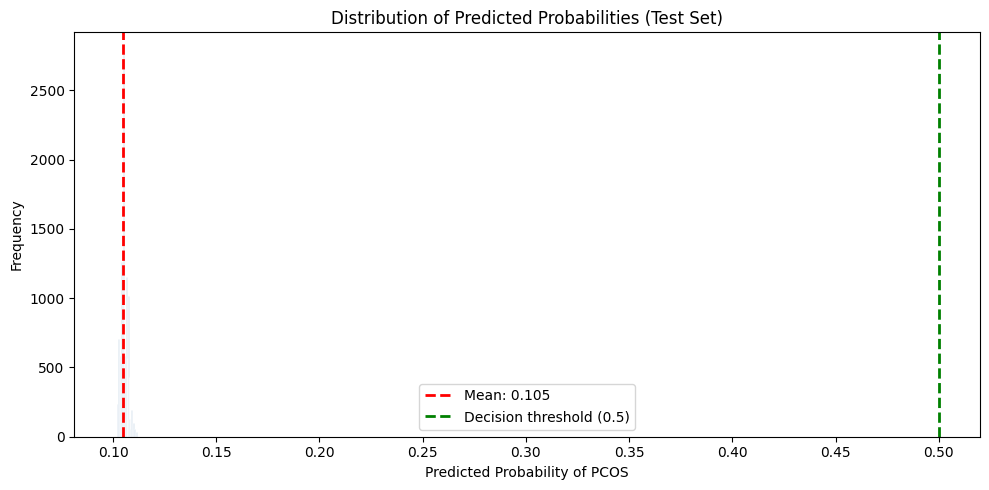

In [ ]:
# Plot distribution of predicted probabilities
plt.figure(figsize=(10, 5))

plt.hist(y_pred_proba, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
plt.axvline(x=y_pred_proba.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_pred_proba.mean():.3f}')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Decision threshold (0.5)')

plt.xlabel('Predicted Probability of PCOS')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

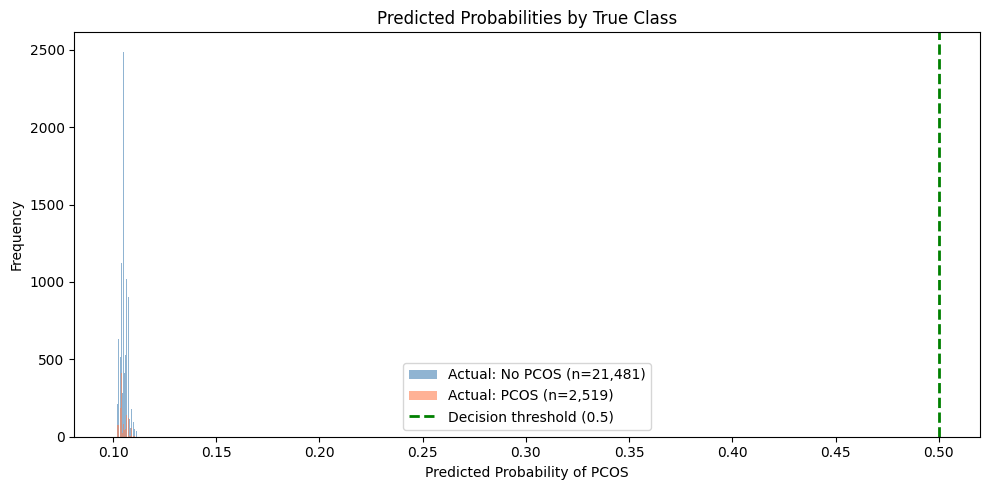

Interpretation:
• If model worked well: PCOS cases (coral) should be shifted RIGHT
• If model worked well: No PCOS cases (blue) should be shifted LEFT
• Our result: Both distributions overlap completely ->b no discrimination


In [ ]:
# Plot predicted probabilities separated by TRUE class
plt.figure(figsize=(10, 5))

# Separate predictions by actual outcome
proba_no_pcos = y_pred_proba[y_test == 0]
proba_pcos = y_pred_proba[y_test == 1]

plt.hist(proba_no_pcos, bins=50, alpha=0.6, label=f'Actual: No PCOS (n={len(proba_no_pcos):,})', color='steelblue')
plt.hist(proba_pcos, bins=50, alpha=0.6, label=f'Actual: PCOS (n={len(proba_pcos):,})', color='coral')

plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Decision threshold (0.5)')

plt.xlabel('Predicted Probability of PCOS')
plt.ylabel('Frequency')
plt.title('Predicted Probabilities by True Class')
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretation:")
print("• If model worked well: PCOS cases (coral) should be shifted RIGHT")
print("• If model worked well: No PCOS cases (blue) should be shifted LEFT")
print("• Our result: Both distributions overlap completely ->b no discrimination")

(8.1) POSTERIOR PREDICTIVE DISTRIBUTION FOR INDIVIDUAL OBSERVATIONS


Lowest Probability (Index: 106277):
  True class: No PCOS
  Predicted probability: 0.1012
  95% Credible Interval: [0.0966, 0.1060]

Middle Probability (Index: 78283):
  True class: No PCOS
  Predicted probability: 0.1035
  95% Credible Interval: [0.0996, 0.1073]

Highest Probability (Index: 42533):
  True class: No PCOS
  Predicted probability: 0.1114
  95% Credible Interval: [0.1040, 0.1192]


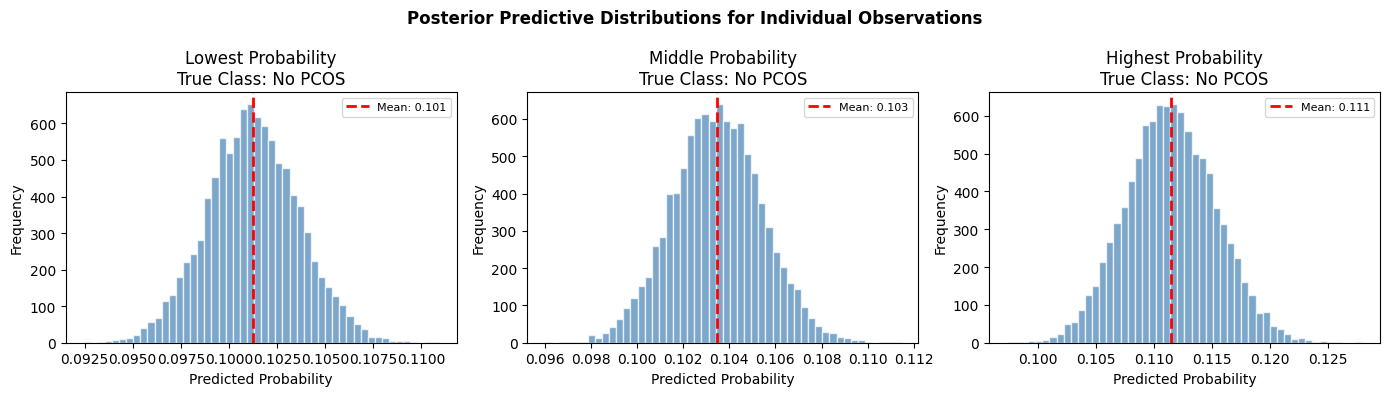

In [ ]:

# Select 3 specific observations from test set
# One with low predicted prob, one medium, one high (relatively)

test_indices = X_test.index.tolist()

# Find observations with different predicted probabilities
low_idx = test_indices[np.argmin(y_pred_proba)]
high_idx = test_indices[np.argmax(y_pred_proba)]
med_idx = test_indices[len(y_pred_proba)//2]

selected_indices = [low_idx, med_idx, high_idx]
selected_labels = ['Lowest Probability', 'Middle Probability', 'Highest Probability']

# Get coefficients and covariance for simulation
coefficients = model_homogeneous.params
cov_matrix = model_homogeneous.cov_params()

# Simulate predictions for each observation
np.random.seed(42)
n_sims = 10000

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, (idx, label) in enumerate(zip(selected_indices, selected_labels)):
    ax = axes[i]
    
    # Get this observation's features (add intercept)
    obs_features = X_test.loc[idx, ['BMI', 'Hirsutism', 'Menstrual Regularity', 
                                      'Insulin Resistance', 'Family History of PCOS']]
    obs_with_intercept = np.array([1] + list(obs_features))  # Add intercept
    
    # Simulate coefficients
    sim_coefs = np.random.multivariate_normal(coefficients, cov_matrix, size=n_sims)
    
    # Calculate predicted probabilities for each simulation
    log_odds_sims = sim_coefs @ obs_with_intercept
    prob_sims = 1 / (1 + np.exp(-log_odds_sims))
    
    # Plot
    ax.hist(prob_sims, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    ax.axvline(x=prob_sims.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {prob_sims.mean():.3f}')
    
    # Mark true class
    true_class = y_test.loc[idx]
    ax.set_title(f'{label}\nTrue Class: {"PCOS" if true_class == 1 else "No PCOS"}')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    
    # Print details
    print(f"\n{label} (Index: {idx}):")
    print(f"  True class: {'PCOS' if true_class == 1 else 'No PCOS'}")
    print(f"  Predicted probability: {prob_sims.mean():.4f}")
    print(f"  95% Credible Interval: [{np.percentile(prob_sims, 2.5):.4f}, {np.percentile(prob_sims, 97.5):.4f}]")

plt.suptitle('Posterior Predictive Distributions for Individual Observations', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

(9) **PREDICTIONS VS TRUE CLASS**

(9.1) PREDICTIONS VS TRUE CLASS

In [ ]:
# Convert probabilities to class predictions (threshold = 0.5)
y_pred_class = (y_pred_proba > 0.5).astype(int)

print(f"Using threshold: 0.5")
print(f"\nPredicted class distribution:")
print(f"  Predicted No PCOS (0): {(y_pred_class == 0).sum():,}")
print(f"  Predicted PCOS (1):    {(y_pred_class == 1).sum():,}")

Using threshold: 0.5

Predicted class distribution:
  Predicted No PCOS (0): 24,000
  Predicted PCOS (1):    0


(9.2) ZERO-RATE BASELINE COMPARISON

In [ ]:
# Zero-rate classifier: always predict the most common class
most_common_class = y_train.mode()[0]
baseline_predictions = np.full(len(y_test), most_common_class)

baseline_accuracy = (baseline_predictions == y_test).mean()
model_accuracy = (y_pred_class == y_test).mean()

print(f"""
Zero-Rate Classifier:
  → Always predicts: {most_common_class} (No PCOS)
  → Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)

Our Model:
  → Accuracy: {model_accuracy:.4f} ({model_accuracy*100:.2f}%)

Difference: {(model_accuracy - baseline_accuracy)*100:.2f}%
""")

if model_accuracy <= baseline_accuracy:
    print(" my model is the equivalent of diagnosing PCOS by flipping a coin! HAPPY PCOS AWARNESS MONTH")
else:
    print(" Our model beats the baseline ")


Zero-Rate Classifier:
  → Always predicts: 0 (No PCOS)
  → Accuracy: 0.8950 (89.50%)

Our Model:
  → Accuracy: 0.8950 (89.50%)

Difference: 0.00%

 my model is the equivalent of diagnosing PCOS by flipping a coin! HAPPY PCOS AWARNESS MONTH


(9.3) CONFUSION MATRIX let's get even more confused haha

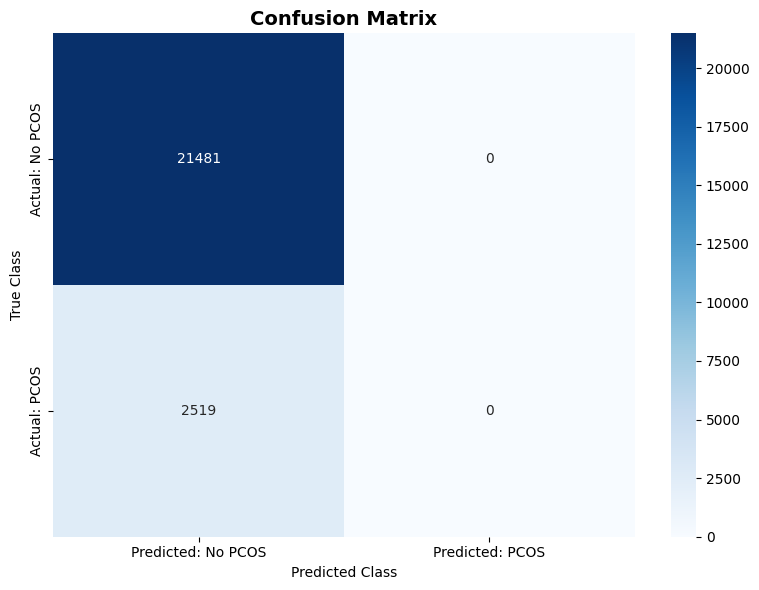

In [ ]:

cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: No PCOS', 'Predicted: PCOS'],
            yticklabels=['Actual: No PCOS', 'Actual: PCOS'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()



In [ ]:
# TRUE  = Model was CORRECT
# FALSE = Model was WRONG

# POSITIVE = Model said "PCOS" (positive diagnosis)
# NEGATIVE = Model said "No PCOS" (negative diagnosis)

(9.4) ROC CURVE

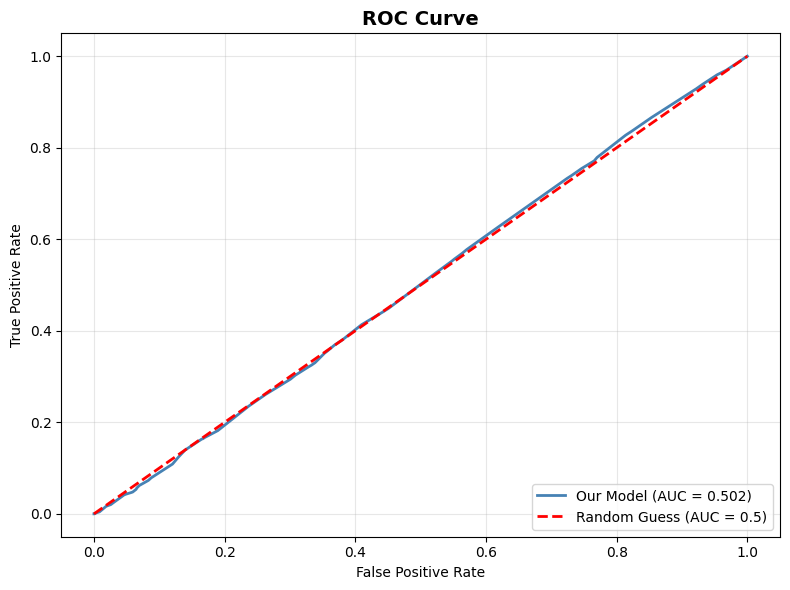

AUC Score: 0.5020

Interpretation:
  → AUC = 0.5 means random guessing
  → Our AUC ≈ 0.5 confirms no predictive power


In [ ]:

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='steelblue', linewidth=2, label=f'Our Model (AUC = {auc_score:.3f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Random Guess (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {auc_score:.4f}")
print(f"\nInterpretation:")
print(f"  → AUC = 0.5 means random guessing")
print(f"  → Our AUC ≈ 0.5 confirms no predictive power")

**CONCLUSIONS**


**ZERO-RATE CLASSIFIER**


Zero-rate classifier found 0.00% difference between the case of ALL patients being pcos free and our model -> our model would be a great tool for pcos awarness months to make sure all women go home happily without a pcos diagnosis (and that's across 75 different countries) 


PS that is sarcasm above


**CONFUSION MATRIX**


The confusion matrix perfectly showcases how the model is confused why someone dared to AI generate this wonderful dataset. The model tells everyone that they have no pcos, missing people who actually have it. The matrix also confirms that the model literally NEVER predicts pcos... I have 2519 people in my test set and the model misses EACH SINGLE TIME. I should definitely share my findings with some hospital in Amsetrdam (sarcasm)


**ROC CURVE**


ROC cruve confirms that my model's prediction is literally the equivalent of flipping a coin = 50%.

(10) **GENERALISATION ERROR**

In [ ]:
# Calculate various metrics on TEST set
test_accuracy = accuracy_score(y_test, y_pred_class)
test_log_loss = log_loss(y_test, y_pred_proba)
test_brier = brier_score_loss(y_test, y_pred_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 60)
print("TEST SET PERFORMANCE METRICS")
print("=" * 60)

print(f"""
1. ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
   - Proportion of correct predictions
   - Misleading here due to class imbalance!

2. LOG-LOSS: {test_log_loss:.4f}
   - Measures prediction uncertainty (lower = better)
   - Penalises confident wrong predictions

3. BRIER SCORE: {test_brier:.4f}
   - Mean squared error of probabilities (lower = better)
   - Measures calibration: how close probabilities are to 0/1 #DO NOT INCLUDE

4. AUC-ROC: {test_auc:.4f}
   - Discrimination ability (0.5 = random, 1.0 = perfect)
   - Best metric for imbalanced data
""")

TEST SET PERFORMANCE METRICS

1. ACCURACY: 0.8950 (89.50%)
   - Proportion of correct predictions
   - Misleading here due to class imbalance!

2. LOG-LOSS: 0.3359
   - Measures prediction uncertainty (lower = better)
   - Penalises confident wrong predictions

3. BRIER SCORE: 0.0939
   - Mean squared error of probabilities (lower = better)
   - Measures calibration: how close probabilities are to 0/1

4. AUC-ROC: 0.5020
   - Discrimination ability (0.5 = random, 1.0 = perfect)
   - Best metric for imbalanced data



In [ ]:

# Baseline log-loss (always predicting the base rate)
baseline_prob = y_train.mean()  # ~0.105
baseline_log_loss = log_loss(y_test, [baseline_prob] * len(y_test))
baseline_brier = brier_score_loss(y_test, [baseline_prob] * len(y_test))

print(f"""
Baseline (predicting {baseline_prob:.1%} for everyone):
  - Log-Loss:    {baseline_log_loss:.4f}
  - Brier Score: {baseline_brier:.4f}

Our Model:
  - Log-Loss:    {test_log_loss:.4f}
  - Brier Score: {test_brier:.4f}

Difference:
  - Log-Loss:    {test_log_loss - baseline_log_loss:.4f} ({'worse' if test_log_loss > baseline_log_loss else 'better'})
  - Brier Score: {test_brier - baseline_brier:.4f} ({'worse' if test_brier > baseline_brier else 'better'})
""")


Baseline (predicting 10.5% for everyone):
  - Log-Loss:    0.3358
  - Brier Score: 0.0939

Our Model:
  - Log-Loss:    0.3359
  - Brier Score: 0.0939

Difference:
  - Log-Loss:    0.0000 (worse)
  - Brier Score: 0.0000 (worse)



In [ ]:

summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Log-Loss', 'Brier Score', 'AUC-ROC'],
    'Our Model': [test_accuracy, test_log_loss, test_brier, test_auc],
    'Baseline': [0.8950, baseline_log_loss, baseline_brier, 0.5000],
    'Better?': [
        'Same' if abs(test_accuracy - 0.8950) < 0.001 else ('Yes' if test_accuracy > 0.8950 else 'No'),
        'Yes' if test_log_loss < baseline_log_loss else 'No',
        'Yes' if test_brier < baseline_brier else 'No',
        'Yes' if test_auc > 0.5 else 'No'
    ]
})

print(summary_df.to_string(index=False))

     Metric  Our Model  Baseline Better?
   Accuracy   0.895042  0.895000    Same
   Log-Loss   0.335857  0.335843      No
Brier Score   0.093945  0.093942      No
    AUC-ROC   0.502049  0.500000     Yes


In [ ]:
# Final interpretation
print("\n" + "=" * 60)
print("FINAL INTERPRETATION")
print("=" * 60)

print("""
GENERALISATION ERROR ASSESSMENT:

1. The model shows NO meaningful improvement over the baseline
   
2. Key evidence:
   • AUC ≈ 0.50 (random guessing)
   • Accuracy = baseline accuracy (89.5%)
   • Log-loss and Brier score similar to baseline

3. Root cause:
   • The features have no predictive relationship with PCOS diagnosis
   • The model defaults to predicting the base rate (~10.5%) for everyone

4. Conclusion:
   • The model does not generalise — it has learned nothing useful
   • This is a data problem, not a methodology problem
   • The analysis pipeline is valid; the features are not predictive
""")


FINAL INTERPRETATION

GENERALISATION ERROR ASSESSMENT:

1. The model shows NO meaningful improvement over the baseline
   
2. Key evidence:
   • AUC ≈ 0.50 (random guessing)
   • Accuracy = baseline accuracy (89.5%)
   • Log-loss and Brier score similar to baseline

3. Root cause:
   • The features have no predictive relationship with PCOS diagnosis
   • The model defaults to predicting the base rate (~10.5%) for everyone

4. Conclusion:
   • The model does not generalise — it has learned nothing useful
   • This is a data problem, not a methodology problem
   • The analysis pipeline is valid; the features are not predictive

